In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from umap import UMAP
%matplotlib inline

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [4]:
# Flatten and combine each feature map into a single feature vector
def flatten_and_combine_maps(*maps):
    flattened_maps = [map.reshape(-1) for map in maps]
    combined_map = np.concatenate(flattened_maps, axis=0)
    return combined_map

In [5]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array

In [6]:
# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

## Create a brain mask derived from the thickness

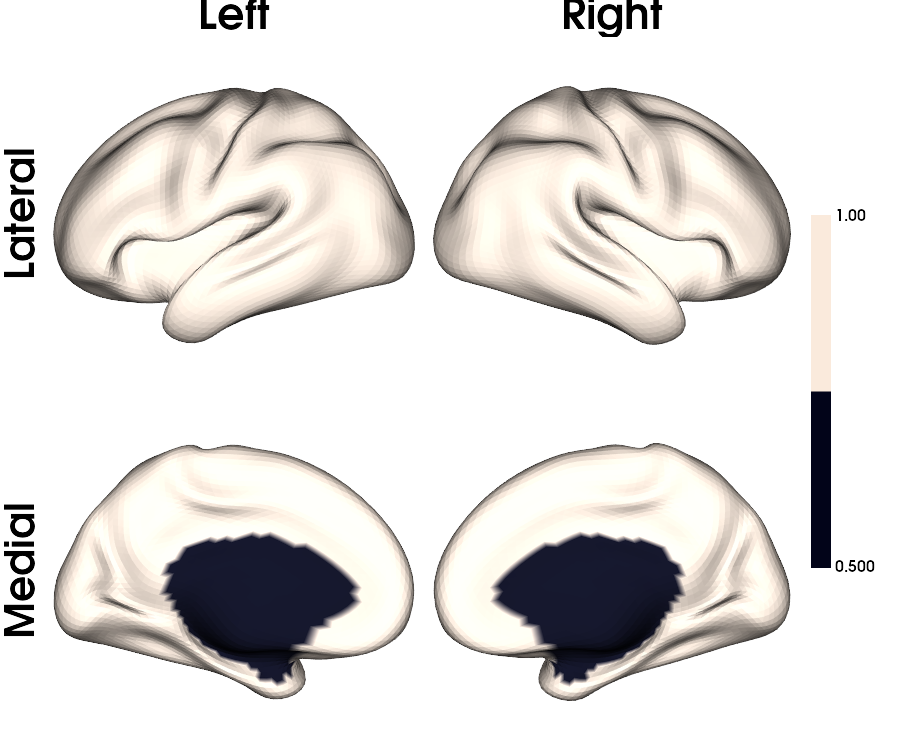

In [7]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

#mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

## fsLR-5k qMRI maps

In [14]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

# Labels and boolean mask
mask_surf = mask_5k != 0


inf32_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [9]:
# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

## Microstructural profile by SWM depth

In [38]:
def load_qmri_intensity(qmri=''):

    # Load CSV file containing subject and session information
    csv_dir = '/data/mica1/03_projects/youngeun/lists'
    csv_file = f"10PNC_{qmri}.csv"
    subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

    # Extract subject and session information from each row
    files = []
    for index, row in subject_session_info.iterrows():
        info = row['info'].split(',')
        subject = index[4:]  # Extract subject ID
        session = info[0][4:].strip()  # Extract session ID
        file_path = f"sub-{subject}/ses-{session}/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii"
        files.extend(glob.glob(file_path))
    
    # Print the file paths
    print("Files used:")
    for file_path in files:
        print(file_path)
    
    # Load intensity profiles from each file
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        # Smooth each intensity
        profile_data_i = smooth_intensities(profile_data)
        # Replace values in midwall with NaN where mask_10k is False
        profile_data_i[:, mask_5k == False] = np.nan
        #profile_data_i = profile_data_i[1:]
        profiles.append(profile_data_i)
    
    profiles = np.array(profiles)

    # Extract subject and session information
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID from the directory name
        subjects.add(subject)

    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")

    return profiles

In [39]:
def process_qmri_profiles():
    # List of qmri values
    qmri_values = ['T1map', 'MTSAT', 'T2star', 'FA', 'FOD', 'ODI']
    
    # Initialize variables to store each matrix
    T1map = None
    MTSAT = None
    T2star = None
    FA = None
    fod_tournier_afd = None

    # Load data and store matrices for each qmri value
    for qmri in qmri_values:
        # Load intensity profiles for the given qmri value
        profiles = load_qmri_intensity(qmri)
        # Store the matrix
        if qmri == 'T1map':
            T1map = profiles
        elif qmri == 'MTSAT':
            MTSAT = profiles
        elif qmri == 'T2star':
            T2star = profiles
        elif qmri == 'FA':
            FA = profiles
        elif qmri == 'FOD':
            fod_tournier_afd = profiles
        elif qmri == 'ODI':
            ODI = profiles

    return T1map, MTSAT, T2star, FA, fod_tournier_afd, ODI

# Call the function to load profiles for each qmri value and store them as matrices
T1map, MTSAT, T2star, FA, FOD, ODI = process_qmri_profiles()

Files used:
sub-PNC003/ses-03/mpc-swm/acq-T1map/sub-PNC003_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC006/ses-03/mpc-swm/acq-T1map/sub-PNC006_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC007/ses-03/mpc-swm/acq-T1map/sub-PNC007_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC009/ses-03/mpc-swm/acq-T1map/sub-PNC009_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC010/ses-03/mpc-swm/acq-T1map/sub-PNC010_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC015/ses-03/mpc-swm/acq-T1map/sub-PNC015_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC016/ses-03/mpc-swm/acq-T1map/sub-PNC016_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC018/ses-03/mpc-swm/acq-T1map/sub-PNC018_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC019/ses-03/mpc-swm/acq-T1map/sub-PNC019_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC022/ses-03/mpc-swm/acq-T1map/sub-PNC022_ses-03_surf-fsLR-5k_desc-intensi

In [419]:
# Check the size of each matrix
print(f"T1map: {T1map.shape}")
print(f"MTSAT: {MTSAT.shape}")
print(f"T2star: {T2star.shape}")
print(f"FA: {FA.shape}")
print(f"FOD: {FOD.shape}")

T1map: (10, 16, 9684)
MTSAT: (10, 16, 9684)
T2star: (10, 16, 9684)
FA: (10, 16, 9684)
FOD: (10, 16, 9684)


## Average Intensity Profies

In [40]:
## Average Intensity Profies
# Calculate mean matrix for each dataset
mean_T1map = np.mean(T1map, axis=0)
mean_MTSAT = np.mean(MTSAT, axis=0)
mean_T2star = np.mean(T2star, axis=0)
mean_FA = np.mean(FA, axis=0)
mean_FOD = np.mean(FOD, axis=0)
mean_ODI = np.mean(ODI, axis=0)

# Check the shape of mean matrices
print(f"Mean T1map matrix shape: {mean_T1map.shape}")
print(f"Mean MTSAT matrix shape: {mean_MTSAT.shape}")
print(f"Mean T2star matrix shape: {mean_T2star.shape}")
print(f"Mean FA matrix shape: {mean_FA.shape}")
print(f"Mean FOD matrix shape: {mean_FOD.shape}")
print(f"Mean ODI matrix shape: {mean_ODI.shape}")

Mean T1map matrix shape: (16, 9684)
Mean MTSAT matrix shape: (16, 9684)
Mean T2star matrix shape: (16, 9684)
Mean FA matrix shape: (16, 9684)
Mean FOD matrix shape: (16, 9684)
Mean ODI matrix shape: (16, 9684)


## Plotting UMAP results

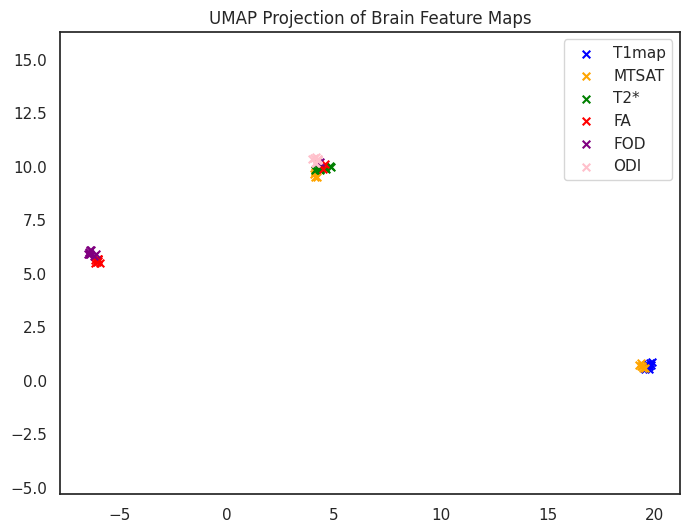

In [20]:
def mask_matrix(matrix):
    cols_to_remove = np.isnan(matrix).any(axis=0)
    masked_matrix = matrix[:, ~cols_to_remove]
    return masked_matrix

masked_mean_T1map = mask_matrix(mean_T1map)
masked_mean_MTSAT = mask_matrix(mean_MTSAT)
masked_mean_T2star = mask_matrix(mean_T2star)
masked_mean_FA = mask_matrix(mean_FA)
masked_mean_FOD = mask_matrix(mean_FOD)
masked_mean_ODI = mask_matrix(mean_ODI)

# Flatten each feature map into feature vectors
flattened_T1map = masked_mean_T1map.reshape((masked_mean_T1map.shape[0], -1))
flattened_MTSAT = masked_mean_MTSAT.reshape((masked_mean_MTSAT.shape[0], -1))
flattened_T2star = masked_mean_T2star.reshape((masked_mean_T2star.shape[0], -1))
flattened_FA = masked_mean_FA.reshape((masked_mean_FA.shape[0], -1))
flattened_FOD = masked_mean_FOD.reshape((masked_mean_FOD.shape[0], -1))
flattened_ODI = masked_mean_ODI.reshape((masked_mean_ODI.shape[0], -1))

# Combine feature vectors into a single array
combined_features = np.concatenate((flattened_T1map, flattened_MTSAT, flattened_T2star, flattened_FA, flattened_FOD, flattened_ODI), axis=0)

# Initialize and apply UMAP model
umap = UMAP(n_components=5)
# umap = UMAP(n_components=2, random_state=42)  # Reduce to 2 dimensions
# random_state for reproducibility: https://umap-learn.readthedocs.io/en/latest/reproducibility.html#umap-reproducibility

# Standardize the feature vectors
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

umap_embedding = umap.fit_transform(scaled_features)

# Visualization
plt.figure(figsize=(8, 6))  # Adjust figure size
colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink']  # Define colors for each data group
start_idx = 0
for i, qmri in enumerate(['T1map', 'MTSAT', 'T2*', 'FA', 'FOD', 'ODI']):
    end_idx = start_idx + T1map.shape[0]  # Calculate end index for current data group
    plt.scatter(umap_embedding[start_idx:end_idx, 0], umap_embedding[start_idx:end_idx, 1], s=30, marker='x', label=qmri, color=colors[i])
    start_idx = end_idx  # Update start index for next data group

plt.title('UMAP Projection of Brain Feature Maps')
plt.gca().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

## UMAP with midwall mask

In [41]:
# Concatenate mean matrices horizontally
concatenated_matrix = np.concatenate((mean_T1map.T, mean_MTSAT.T, mean_T2star.T, mean_FA.T, mean_FOD.T, mean_ODI.T), axis=1)

# Check the shape of concatenated matrix
print(f"Concatenated matrix shape: {concatenated_matrix.shape}")

Concatenated matrix shape: (9684, 96)


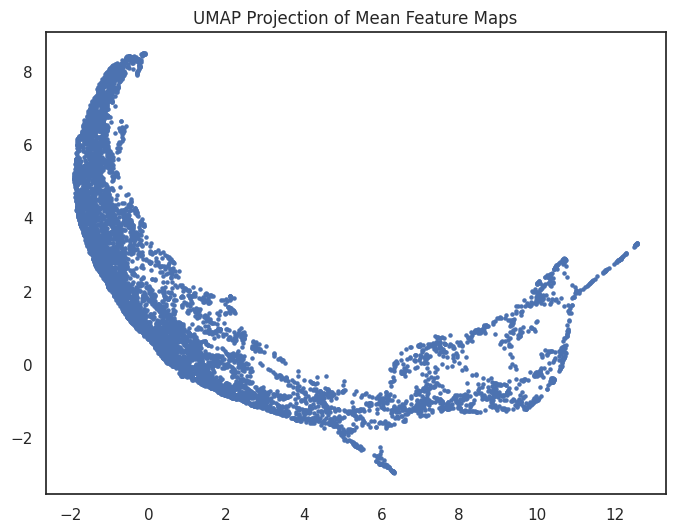

In [27]:
# Initialize UMAP model
umap = UMAP(n_components=5)

# Identify rows with NaN values and exclude them
nan_rows = np.isnan(concatenated_matrix).any(axis=1)
concatenated_matrix = concatenated_matrix[~nan_rows]

# Apply UMAP to the concatenated matrix
umap_embedding = umap.fit_transform(concatenated_matrix)

# Get the index of the non medial wall regions
indx = np.where(mask_5k==1)[0]

# Map gradients to surface
umap_dimensions = 5
umap_list = [None] * umap_dimensions

# Boolean mask
mask_surf = mask_5k != 0

for i, u in enumerate(umap_embedding.T):
    # create a new array filled with NaN values
    u_nan = np.full(mask_surf.shape, np.nan)
    
    u_nan[indx] = u
    umap_list[i] = u_nan

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5)
plt.title('UMAP Projection of Mean Feature Maps')
plt.show()

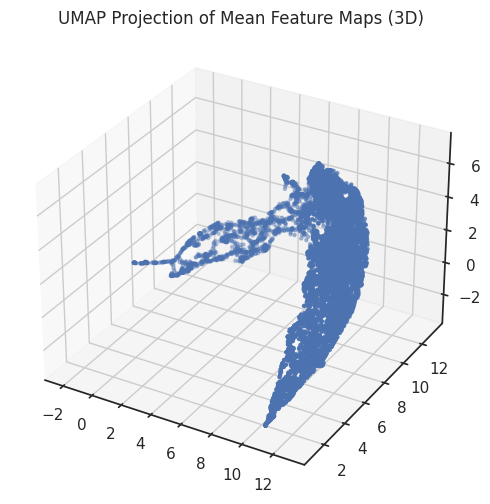

In [30]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize UMAP model with 3 components
umap_3d = UMAP(n_components=3)

# Apply UMAP to the concatenated matrix
umap_embedding_3d = umap_3d.fit_transform(concatenated_matrix)

# Visualization in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embedding_3d[:, 0], umap_embedding_3d[:, 1], umap_embedding_3d[:, 2], s=5)
ax.set_title('UMAP Projection of Mean Feature Maps (3D)')
plt.show()

## Plotting UMAP results on the brain (with midwall mask)

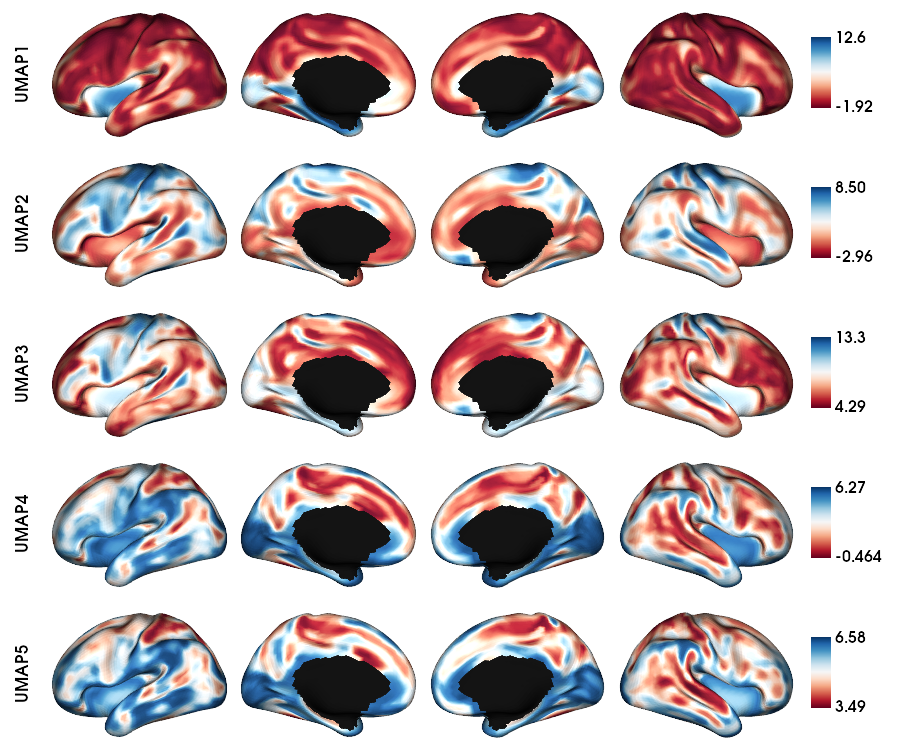

In [48]:
# Labels for plotting based on Nplot
labels=['UMAP'+str(x) for x in list(range(1,umap_dimensions+1))]

# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_list, cmap='RdBu', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

## UMAP without midwall mask

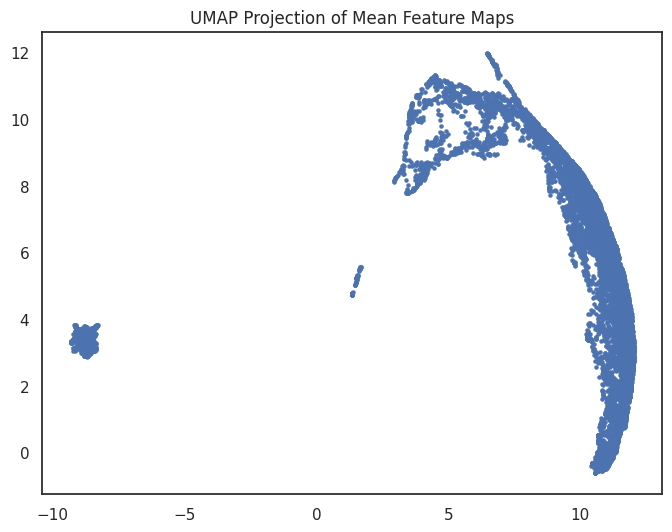

In [432]:
# Initialize UMAP model
umap = UMAP(n_components=5)

concatenated_matrix[np.isnan(concatenated_matrix)] = 0

# Apply UMAP to the concatenated matrix
umap_embedding = umap.fit_transform(concatenated_matrix)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5)
plt.title('UMAP Projection of Mean Feature Maps')
plt.show()

## Plotting UMAP results on the brain (without midwall mask)

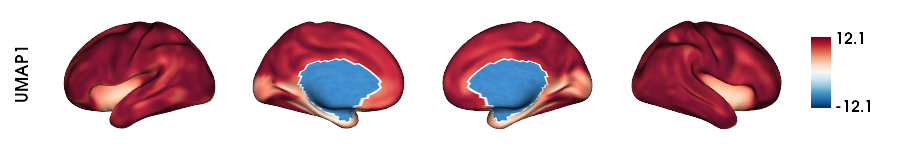

In [433]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_embedding[:, 0], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 150), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': ['UMAP1']}, screenshot=False)

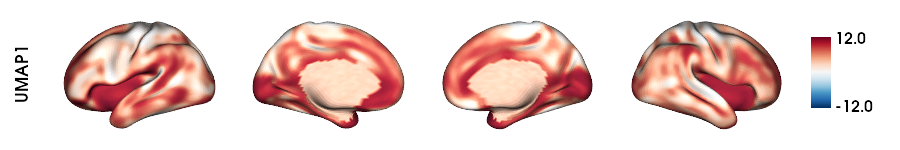

In [434]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_embedding[:, 1], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 150), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': ['UMAP1']}, screenshot=False)

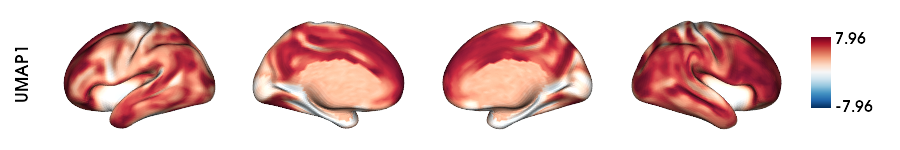

In [435]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_embedding[:, 2], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 150), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': ['UMAP1']}, screenshot=False)

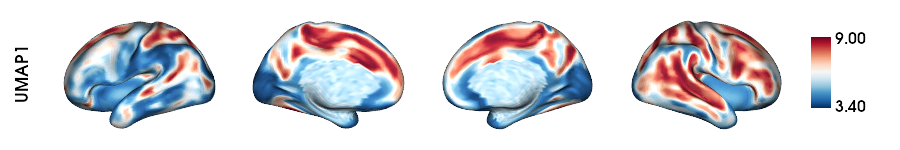

In [436]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_embedding[:, 3], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 150), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': ['UMAP1']}, screenshot=False)

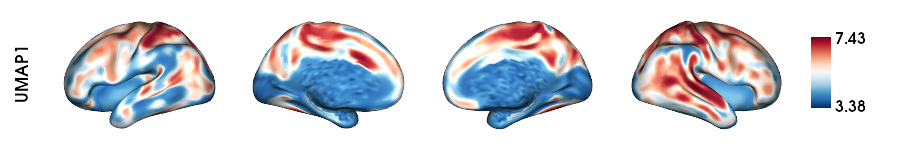

In [437]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=umap_embedding[:, 4], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 150), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': ['UMAP1']}, screenshot=False)

In [194]:
!pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:001 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.8 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 28.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.9 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 4.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 25.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.7 MB/s eta 0:00:000m eta 0:00:01
   ━━━

## Plotting UMAP connectivity

<Axes: >

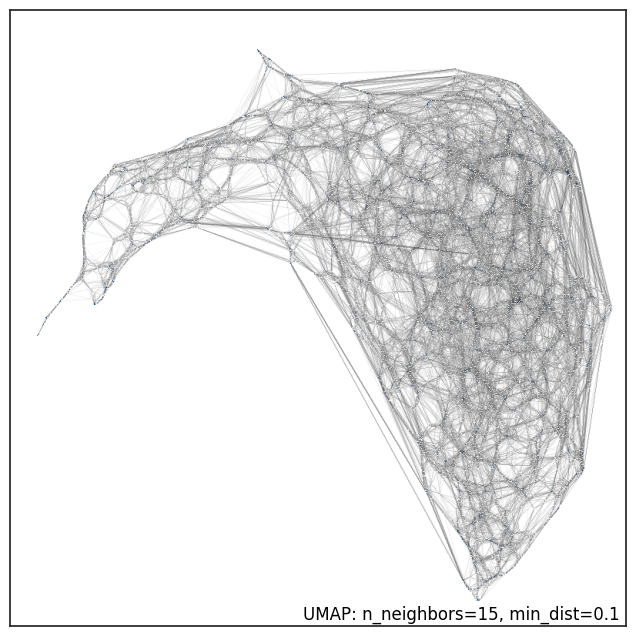

In [427]:
import umap.plot
import sklearn.datasets
import pandas as pd
import numpy as np
import umap

mapper = umap.UMAP().fit(concatenated_matrix)
umap.plot.connectivity(mapper, show_points=True)

## mMPC calculation

In [42]:
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

In [43]:
mMPC = build_mpc(concatenated_matrix.T, mask_surf) # compute mMPC

/tmp/ipykernel_2902634/3648365008.py:44: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


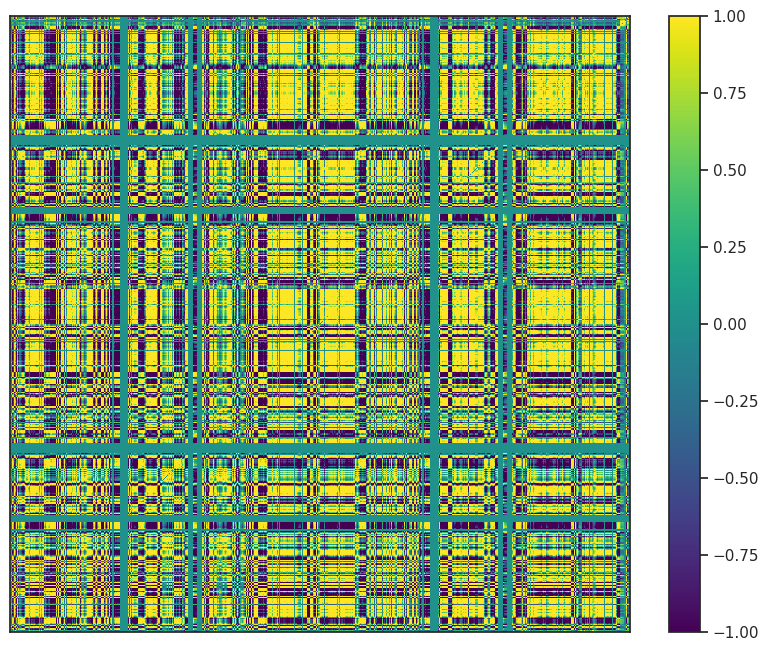

In [58]:
# Adjust the figure size as per your requirement
plt.figure(figsize=(10, 8))  # Adjust the values (width, height) as needed

# Plot the pcolormesh
pcm = plt.pcolormesh(mMPC, cmap='viridis', shading='auto', vmin=-1, vmax=1)

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()

In [80]:
# Calculate the sum of each column
column_sums = np.sum(mMPC, axis=0)

# Sort the indices of columns based on their sums
sorted_indices = np.argsort(column_sums)

# Rearrange columns based on sorted indices
sorted_mMPC = mMPC[:, sorted_indices]
sorted_mMPC = sorted_mMPC[sorted_indices, :]

In [81]:
sum_cols = np.sum(sorted_mMPC, axis=0)
low_sum_cols = np.where(sum_cols < 0.001)[0]
filtered_matrix = np.delete(sorted_mMPC, low_sum_cols, axis=1)

sum_rows = np.sum(filtered_matrix, axis=1)
low_sum_rows = np.where(sum_rows < 0.001)[0]
filtered_matrix = np.delete(filtered_matrix, low_sum_rows, axis=0)

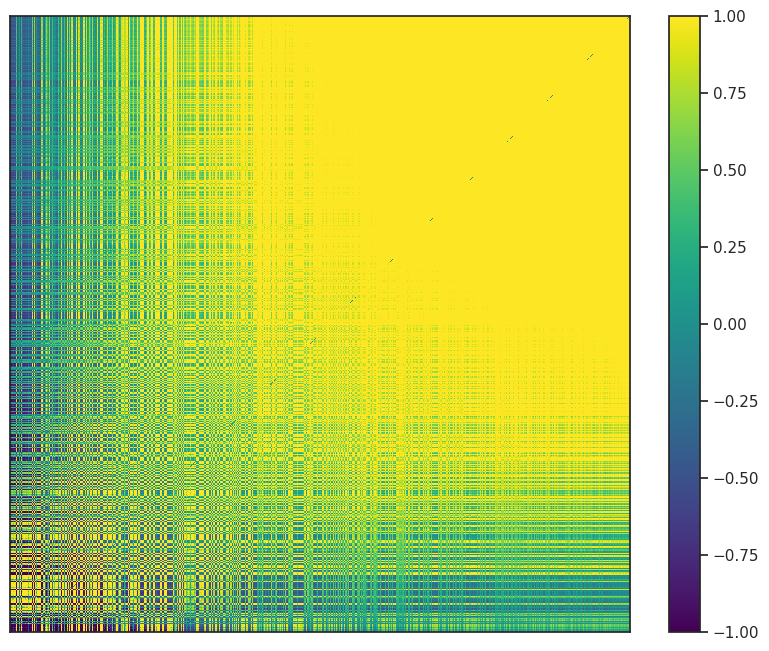

In [83]:
# Adjust the figure size as per your requirement
plt.figure(figsize=(10, 8))  # Adjust the values (width, height) as needed

# Plot the pcolormesh
pcm = plt.pcolormesh(filtered_matrix, cmap='viridis', shading='auto', vmin=-1, vmax=1)

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()

In [151]:
# Normalize each column to be between 0 and 1
mean_concatenated_data = np.mean(concatenated_data, axis=0)

print(mean_concatenated_data.shape)

(96, 9684)


In [209]:
# Concatenate mean matrices horizontally
mean_R1 = 1/mean_T1map * 1000
mean_concatenated_data = np.concatenate((mean_R1.T, mean_MTSAT.T, mean_T2star.T, mean_FA.T, mean_FOD.T, mean_ODI.T), axis=1)

mean_concatenated_data[mask_5k == False] = np.nan
# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_concatenated_data).any(axis=1)
mean_concatenated_data = mean_concatenated_data[valid_rows]

min = np.min(mean_concatenated_data, axis=1)
max = np.max(mean_concatenated_data, axis=1)
normalized_data = (mean_concatenated_data - min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])

In [222]:
normalized_data

array([[0.02381963, 0.02367456, 0.02357669, ..., 0.00549046, 0.00622165,
        0.00684026],
       [0.02531713, 0.02528798, 0.02523497, ..., 0.00432774, 0.00543511,
        0.00655109],
       [0.02200348, 0.02191542, 0.02183483, ..., 0.00939954, 0.00994944,
        0.01037663],
       ...,
       [0.02336431, 0.02332458, 0.02328058, ..., 0.00958767, 0.00969296,
        0.0097504 ],
       [0.02440463, 0.02437793, 0.02435437, ..., 0.00827343, 0.00836874,
        0.00841838],
       [0.02333743, 0.02331059, 0.023268  , ..., 0.0080307 , 0.00814915,
        0.00821205]], dtype=float32)

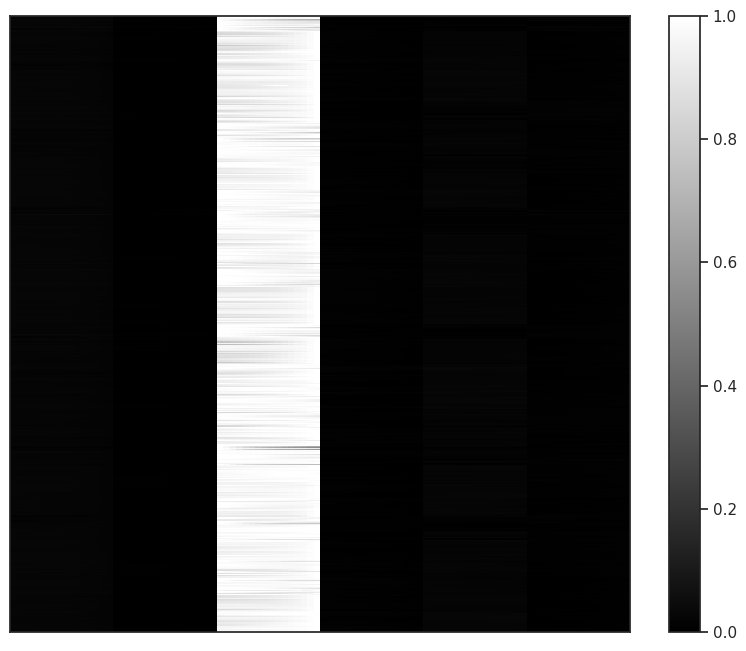

In [215]:
# Adjust the figure size as per your requirement
plt.figure(figsize=(10, 8))  # Adjust the values (width, height) as needed

# Plot the pcolormesh
pcm = plt.pcolormesh(normalized_data, cmap='gray', shading='auto', vmin = 0, vmax = 1)

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()

In [84]:
concatenated_matrix.shape

(9684, 96)

In [44]:
# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return(MPCgm, grad)

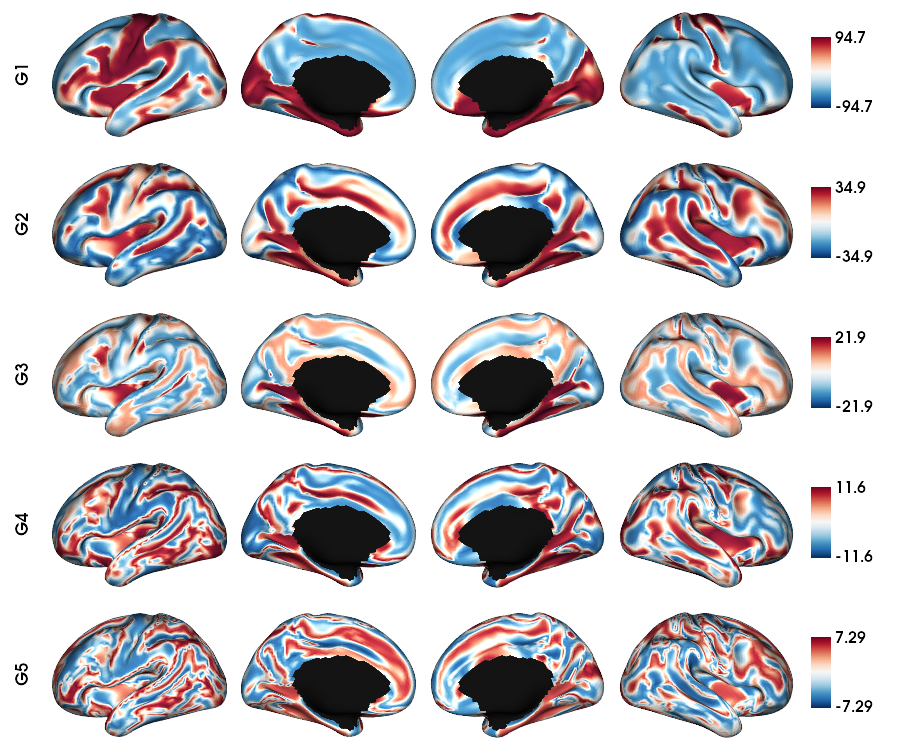

In [60]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## Calculate mMPC by subject + Average

In [46]:
concatenated_data = np.concatenate((T1map, MTSAT, T2star, FA, FOD), axis=1)

mMPC_list = [build_mpc(concatenated_data[i], mask_surf) for i in range(10)]
mMPC_mean = np.mean(mMPC_list, axis=0)

# Calculate the gradients
Ngrad=5
MPC_average, grad_average = mpc_dm(mMPC_mean, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

/tmp/ipykernel_2902634/3648365008.py:44: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


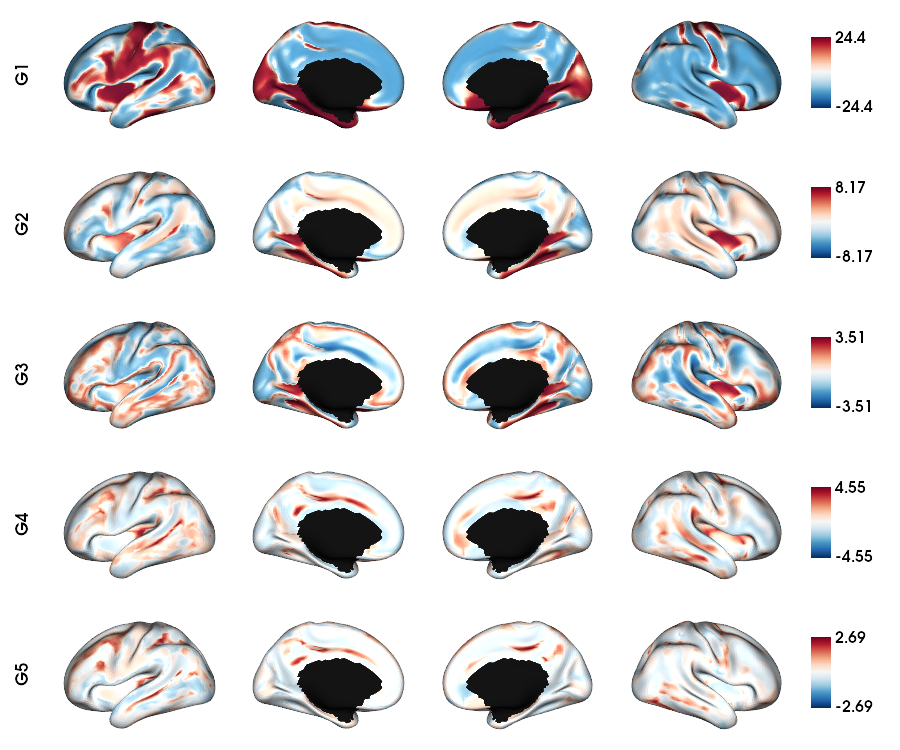

In [47]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad_average, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)